Реализуем градиентный спуск для задачи поиска оптимальных коэффициентов в MSE регрессии!

In [216]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Имеем 1000 объектов и 10 признаков у каждого (+таргет)!

Обучим модель линейной регрессии:

$$
a(x) = \beta_1 d_{1} + \beta_2 d_{2} + \beta_3 d_{3} + \beta_4 d_{4} + \beta_5 d_{5} + \beta_6 d_{6} + \beta_7 d_{7} + \beta_8 d_{8} + \beta_9 d_{9} + \beta_{10} d_{10} + \beta_0
$$

Которая минимизирует MSE:

$$
Q(a(X), Y) = \sum_i^{1000} (a(x_i) - y_i)^2
$$

In [217]:
data = pd.read_csv('data.csv')

data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target
0,0.113768,0.930064,0.330528,0.010987,0.265703,0.699462,0.058465,0.431643,0.650958,0.751820,30.147094
1,0.380048,0.485946,0.870232,0.473401,0.454516,0.500864,0.471723,0.234329,0.072982,0.008372,21.424402
2,0.768462,0.217706,0.727438,0.718377,0.452155,0.434638,0.043989,0.972489,0.450133,0.378157,31.422056
3,0.606637,0.604335,0.540332,0.491236,0.325632,0.206348,0.825767,0.332475,0.955518,0.162811,31.308588
4,0.119770,0.469718,0.632829,0.504207,0.238259,0.452457,0.775360,0.174262,0.117621,0.218883,23.322751


Обучим коэффициенты линейной регрессии с помощью библиотеки <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html"> **sklearn** </a>

Отдельно выведем оценку свободного коэффициента  ($\beta_0$ при $d_0 = 1$)

In [218]:
from sklearn.linear_model import LinearRegression

### Your code is here

# Split data into features (X) and target variable (y)
X = data.drop('target', axis=1)
y = data['target']

# Create linear regression object and fit to data
reg = LinearRegression().fit(X, y)

# Print estimated intercept (free coefficient)
print(reg.intercept_)

4.37315703870712


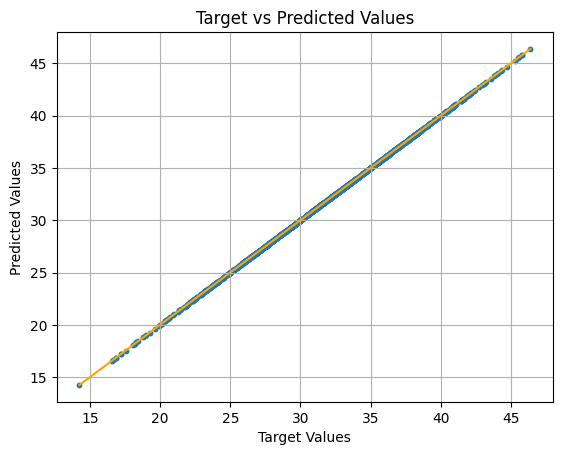

In [219]:
# Make predictions on the data
y_pred = reg.predict(X)

# Create scatter plot of target vs predicted values
plt.scatter(y, y_pred, s=10)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'orange')
plt.xlabel("Target Values")
plt.ylabel("Predicted Values")
plt.title("Target vs Predicted Values")
plt.grid()
plt.show()

Теперь вам необходимо реализовать класс для оптимизации коэффициентов линейной регрессии МНК.
Подразумевается, что на вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента (чтобы он не взорвался)
- значение **threshold**'а для критерия останова (когда мы считаем, что мы сошлись к оптимуму)
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент $\beta_0$.

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадратической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate = $\eta$**: $\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \nabla Q(\beta^{(n)})$

- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. Иными словами, $|Q(\beta^{(n)}) - Q(\beta^{(n+1)})| < threshold$.

P.S. установите в **__init__** аттрибут экземпляра с названием **iteration_loss_dict**, который будет устроен следующим образом: на каждой итерации мы будем добавлять в словарь пару ключ-значение, где ключем будет номер итерации $n$, а значением - среднеквадратическая ошибка в точке $\beta^{(n)}$. Это пригодится нам в будущем для визуализации.

### Hint: пример вычисления производной

$$
Q(a, X) = \frac{1}{N}\cdot\sum_{i=1}^N (\beta_1 \cdot d_{i1} + ... + \beta_n \cdot d_{in} - y_i)^2
$$

Выше - минимизируемая функция. Она зависит от n переменных: $\beta_1, ..., \beta_n$. Вектор-градиент - матрица с одной строчкой, состоящей из производных 1го порядка по всем переменным.

$$
\nabla Q(a, X) = (Q'_{\beta_1} \;\;\; Q'_{\beta_2} \;\;\; ... \;\;\; Q'_{\beta_{n-1}}  \;\;\;  Q'_{\beta_n})
$$

Пример вычисления производной по первой переменной:

$$
Q'_{\beta_1} = \frac{2}{N} \cdot \sum_{i=1}^N d_{i1} (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

Скажем, для нашего датасета X, Y вычислим эту саму производную при начальных единичных коэффициентах $\beta_{start} = (1 \;\;\; 1 \;\;\; ...)$

Получим для каждого объекта в начале выражение из скобочек: 
$$
\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i
$$

In [220]:
### Инициализируем точку для коэффициентов в виде вектора из единичек
initial_betas = np.ones(X.shape[1])

### Получим выражение выше для каждого объекта. 
### Для этого скалярно перемножим строчки из X на наши beta

scalar_value = np.dot(X, initial_betas.reshape(-1, 1)).ravel()
scalar_value = (scalar_value - y).values

Теперь полученное значение для каждого объекта умножим на соответствующее значение признака $d_1$:

$$
d_{i1} \cdot (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

In [221]:
### Возьмем столбик со значениями 1 признака

d_i1 = X.values[:, 0]

### Умножим каждый объект на соответствующее значение признака
scalar_value = scalar_value * d_i1

In [222]:
### Наконец, умножим все на 2 и усреднимся, 
### чтобы получить значение производной по первому параметру

2 * np.mean(scalar_value)

-27.62384887912409

### Эта логика поможем Вам при реализации класса!

learn(self)

метод возвращает итоговую среднеквадратическую ошибку.
метод итеративно вычисляет среднеквадратическую ошибку и вектор-градиент. номер итерации и MSE записываются в словарь *iteration_loss_dict*. критерий останова срабатывает тогда, когда абсолютное значение разницы двух последних MSE меньше *self.threshold*.

In [223]:
class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии 
    """

    def __init__(self, samples: pd.DataFrame, targets: pd.DataFrame,
                 learning_rate: float = 1e-3, threshold = 1e-6, copy: bool = True):
        """
        self.samples - матрица признаков
        self.targets - вектор таргетов
        self.beta - вектор из изначальными весами модели == коэффициентами бета (состоит из единиц)
        self.learning_rate - параметр *learning_rate* для корректировки нормы градиента
        self.threshold - величина, меньше которой изменение в loss-функции означает остановку градиентного спуска
        iteration_loss_dict - словарь, который будет хранить номер итерации и соответствующую MSE
        copy: копирование матрицы признаков или создание изменения in-place
        """
        ### Your code is here
        
        # Матрица признаков
        self.samples = samples.copy() if copy else samples
        
        # Вектор таргетов
        self.targets = targets
        
        # Вектор из изначальными весами модели == коэффициентами бета (состоит из единиц)
        self.beta = np.ones(self.samples.shape[1])
        
        # Параметр *learning_rate* для корректировки нормы градиента
        self.learning_rate = learning_rate
        
        # Величина, меньше которой изменение в loss-функции означает остановку градиентного спуска
        self.threshold = threshold
        
        # Словарь, который будет хранить номер итерации и соответствующую MSE
        self.iteration_loss_dict = {}
        
        # Копирование матрицы признаков или создание изменения in-place
        self.copy = copy
        
    def add_constant_feature(self):
        """
        Метод для создания константной фичи в матрице объектов samples
        Метод создает колонку с константным признаком (interсept) в матрице признаков.
        Hint: так как количество признаков увеличилось на одну, не забудьте дополнить вектор с изначальными весами модели!
        """
        ### Your code is here
        
        # Создаем колонку с константным признаком (interсept) в матрице признаков
        if self.copy:
            self.samples = self.samples.copy()
        
        # Добавляем колонку с константным признаком (interсept) в матрице признаков
        self.samples.insert(0, 'intercept', 1)
        
        # Дополняем вектор с изначальными весами модели
        self.beta = np.ones(self.samples.shape[1])
        
        
        
    def calculate_mse_loss(self) -> float:
        """
        Метод для расчета среднеквадратической ошибки
        
        :return: среднеквадратическая ошибка при текущих весах модели : float
        """
        ### Your code is here
        
        # Считаем среднеквадратическую ошибку при текущих весах модели
        y_pred = self.samples.dot(self.beta)
        
        # Считаем среднеквадратическую ошибку при текущих весах модели
        return np.mean((self.targets - y_pred) ** 2)

    def calculate_gradient(self) -> np.ndarray:
        """
        Метод для вычисления вектора-градиента
        Метод возвращает вектор-градиент, содержащий производные по каждому признаку.
        Сначала матрица признаков скалярно перемножается на вектор self.beta, и из каждой колонки
        полученной матрицы вычитается вектор таргетов. Затем полученная матрица скалярно умножается на матрицу признаков.
        Наконец, итоговая матрица умножается на 2 и усредняется по каждому признаку.
        
        :return: вектор-градиент, т.е. массив, содержащий соответствующее количество производных по каждой переменной : np.ndarray
        """
        ### Your code is here
        
        # Считаем вектор-градиент
        y_pred = self.samples.dot(self.beta)
        
        # 
        errors = y_pred - self.targets
        
        # возвращает вектор-градиент, содержащий производные по каждому признаку.
        return 2 * self.samples.T.dot(errors) / self.samples.shape[0]
    
    
    def iteration(self):
        """
        Обновляем веса модели в соответствии с текущим вектором-градиентом
        """
        ### Your code is here
        
        self.beta = self.beta - self.learning_rate * self.calculate_gradient()
        
    def learn(self):
        """
        Итеративное обучение весов модели до срабатывания критерия останова
        Запись mse и номера итерации в iteration_loss_dict
        
        Описание алгоритма работы для изменения бет:
            Фиксируем текущие beta -> start_betas
            Делаем шаг градиентного спуска
            Записываем новые beta -> new_betas
            Пока |L(new_beta) - L(start_beta)| >= threshold:
                Повторяем первые 3 шага
                
        Описание алгоритма работы для изменения функции потерь:
            Фиксируем текущие mse -> previous_mse
            Делаем шаг градиентного спуска
            Записываем новые mse -> next_mse
            Пока |(previous_mse) - (next_mse)| >= threshold:
                Повторяем первые 3 шага
        """
        ### Your code is here
        
        self.objective_values = []
        iteration = 0
        while True:
            mse = self.calculate_mse_loss()
            self.objective_values.append(mse)
            if len(self.objective_values) > 1 and abs(self.objective_values[-1] - self.objective_values[-2]) < self.threshold:
                break
            self.iteration()
            iteration += 1
        

Обучим коэффициенты линейной модели с помощью реализованного нами градиентного спуска, не забыв добавить свободную переменную. Получились ли такие же коэффициенты, как и при использовании **LinearRegression** из **sklearn**? Если нет, то почему они отличаются, на Ваш взгляд, и сильно ли?

In [224]:
# Отправляем данные в класс
GD = GradientDescentMse(samples=X, targets=y)
# Добавляем константный признак
GD.add_constant_feature()
# Запускаем обучение
GD.learn()

print('Веса модели при переменных d0, d1, ..., d10 равны соответственно: \n\n' + str(GD.beta))

Веса модели при переменных d0, d1, ..., d10 равны соответственно: 

intercept     4.948547
feature_1     0.887333
feature_2     1.901007
feature_3     2.880636
feature_4     3.876626
feature_5     4.896235
feature_6     5.891262
feature_7     6.892548
feature_8     7.903119
feature_9     8.875801
feature_10    9.861096
dtype: float64


In [239]:
print(GD.iteration_loss_dict)

{}


Попробуйте теперь изменить значения **learning_rate** и/или **threshold**. Например, установите длину шага $\eta = 1$. Что произошло и почему такое возможно?

In [225]:
# testing threshold = 1 
GD = GradientDescentMse(samples=X, targets=y, threshold=1)
GD.add_constant_feature()
GD.learn()

print('Веса модели при переменных d0, d1, ..., d10 равны соответственно: \n\n' + str(GD.beta))

Веса модели при переменных d0, d1, ..., d10 равны соответственно: 

intercept     5.942690
feature_1     3.520114
feature_2     3.473134
feature_3     3.352192
feature_4     3.393569
feature_5     3.476969
feature_6     3.608862
feature_7     3.567085
feature_8     3.685867
feature_9     3.590834
feature_10    3.638360
dtype: float64


In [226]:
GD = GradientDescentMse(samples=X, targets=y, learning_rate=0.1, threshold=1)
GD.add_constant_feature()
GD.learn()

print('Веса модели при переменных d0, d1, ..., d10 равны соответственно: \n\n' + str(GD.beta))

Веса модели при переменных d0, d1, ..., d10 равны соответственно: 

intercept     8.189159
feature_1     4.566178
feature_2     4.512762
feature_3     4.375823
feature_4     4.462750
feature_5     4.614273
feature_6     4.822320
feature_7     4.791590
feature_8     4.991352
feature_9     4.885052
feature_10    4.985476
dtype: float64


Установка `learning_rate` равным 1 может привести к слишком большим шагам градиентного спуска, в результате чего обучение может расходиться, а не сходиться к оптимальным коэффициентам. В итоге вектор-градиент станет слишком большим, и при обновлении коэффициентов будет происходить перепрыгивание оптимального значения. Таким образом, если `learning_rate` установлен на слишком большое значение, процесс оптимизации может не сойтись.

При установке значения `threshold` слишком малым, мы можем столкнуться с тем, что процесс оптимизации будет слишком долгим или вообще не завершится, потому что оптимизация остановится, когда разница между ошибкой на текущей и предыдущей итерациях будет меньше, чем установленный порог. Если установить этот порог слишком маленьким, то потребуется больше итераций для сходимости. Однако слишком большое значение порога может привести к тому, что процесс оптимизации не сойдется вообще, если слишком быстро сойдется в локальный минимум.

В машинном обучении зачастую исследуют так называемые **траектории обучения** (или **learning paths**). Это графики, показывающие, как во время обучения при каждой следующей итерации изменялось значение минимизируемого функционала. Постройте такие траектории для различных **learning rate**'ов и **threshold**'ов. Советуем использовать для этого разобранный на занятиях **add_subplot** метод. 

Возьмите следующие **threshold**'ы: 1e-2, 1e-3, 1e-4, 1e-5

И следующие значения **learning rate**'а: 1e-1, 5e-2, 1e-2, 5e-3, 1e-3

У вас должен получиться примерно такой график (см. ниже, значения среднеквадратической ошибки мы намеренно замазали оранжевыми квадратиками, чтобы не спойлерить вам результаты).

Как и подобает хорошим Data Scientist'ам, не забывайте подписывать графики, оси, а так же делать элементы ваших визуализаций читаемыми и видимыми. Советуем пересмотреть методы и параметры форматирования из лекции.

При какой комбинации **threshold** - **learning rate** из возможных предложенных выше, получается достигнуть меньшего значения нашей минимизируемой функции? Запишите каждой из значений в легенде на графиках.


<img src="https://i.imgur.com/38kZTkW.png" width="300">

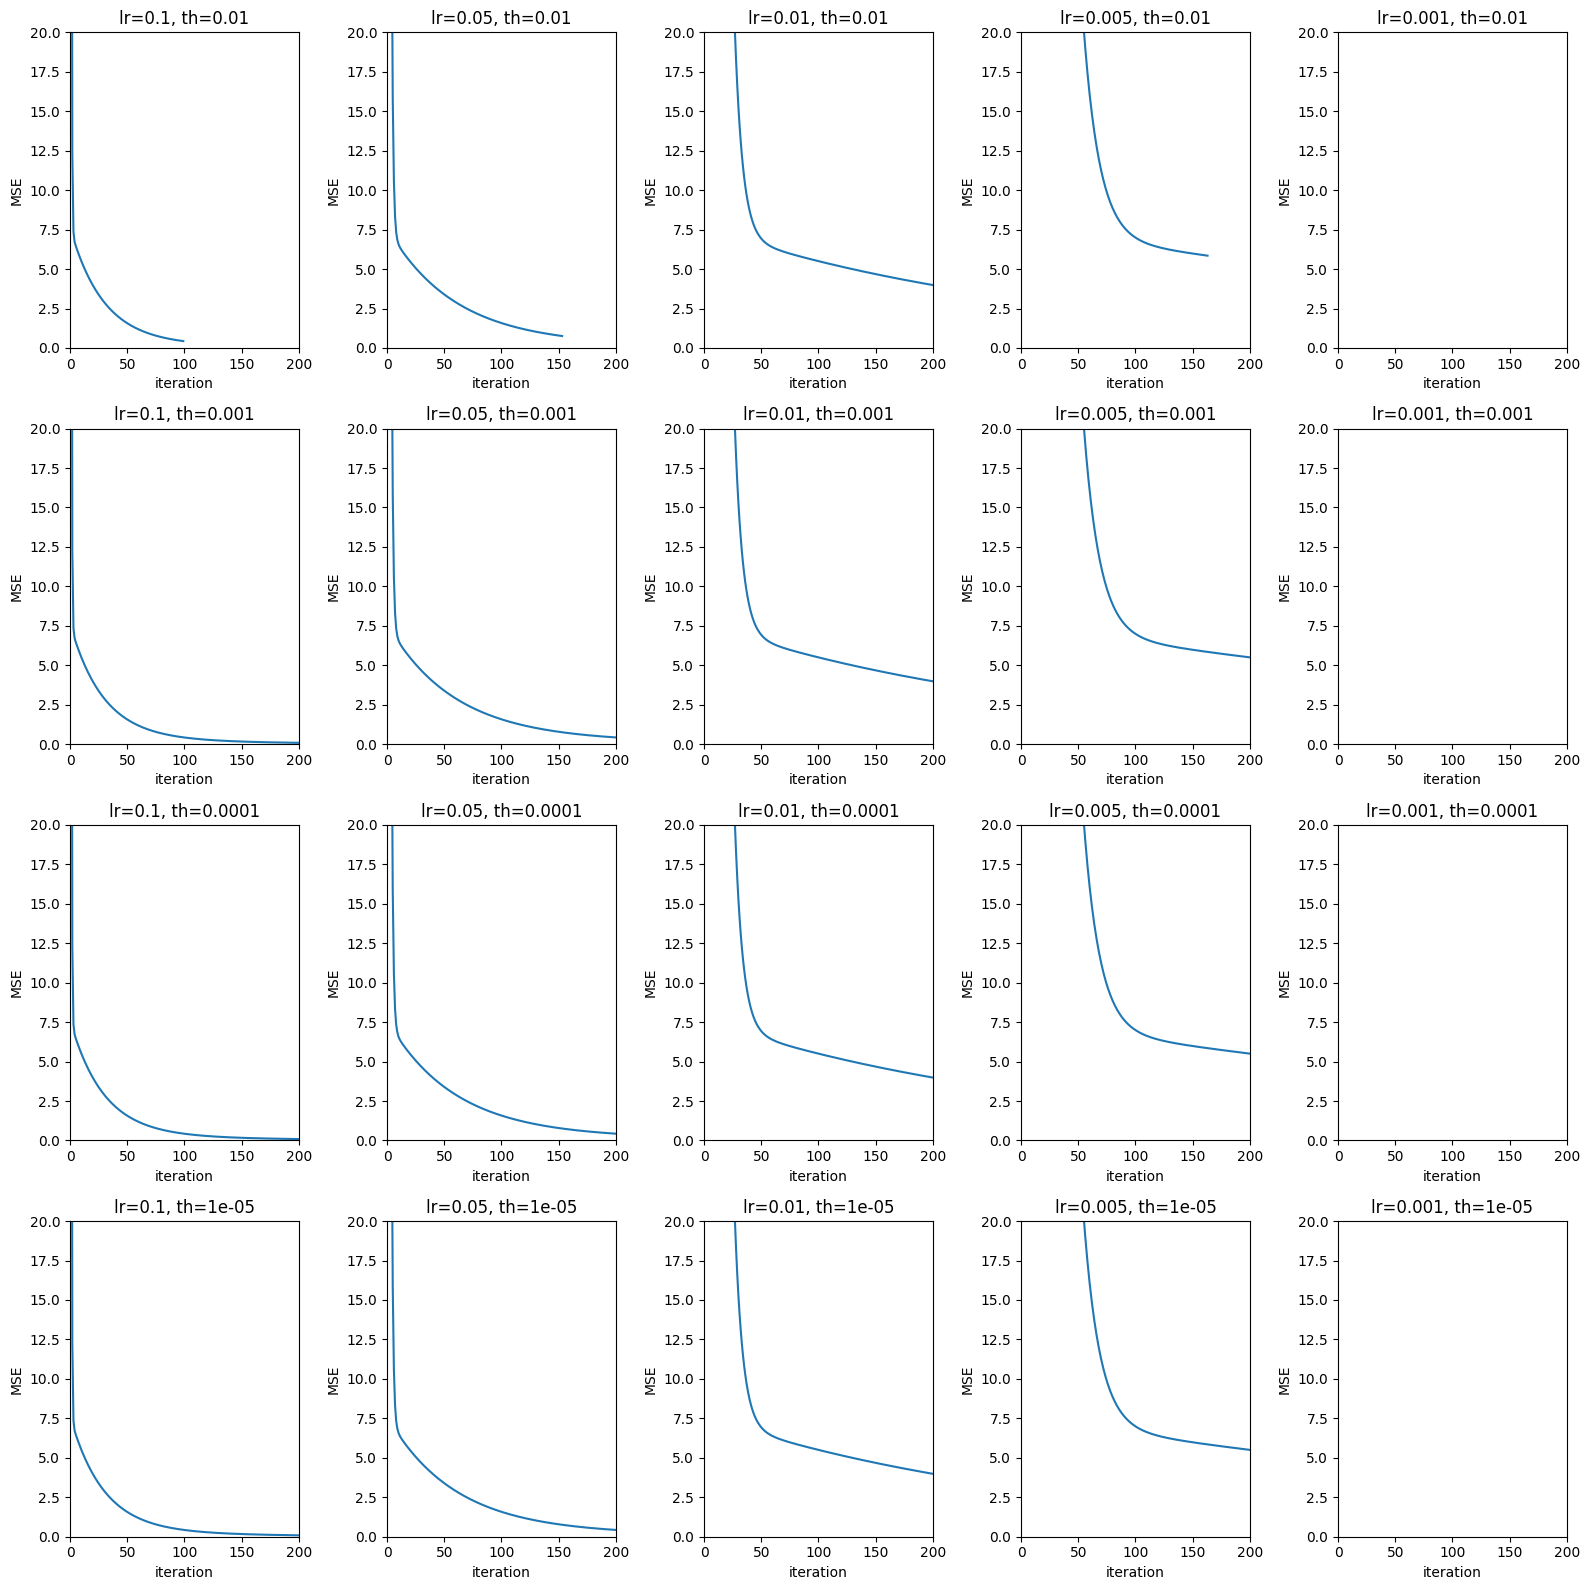

In [237]:
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
thresholds = [0.01, 0.001, 0.0001, 0.00001]


fig, axs = plt.subplots(len(thresholds), len(learning_rates), figsize=(16, 16))

for i, threshold in enumerate(thresholds):
    for j, learning_rate in enumerate(learning_rates):
        gd = GradientDescentMse(X, y, learning_rate=learning_rate, threshold=threshold)
        gd.add_constant_feature()
        gd.learn()
        axs[i, j].plot(gd.objective_values)
        axs[i, j].set_title(f"lr={learning_rate}, th={threshold}")
        axs[i, j].set_xlabel("iteration")
        axs[i, j].set_ylabel("MSE")
        
        axs[i, j].set_ylim(0, 20)
        axs[i, j].set_xlim(0, 200)

plt.tight_layout()
plt.show()


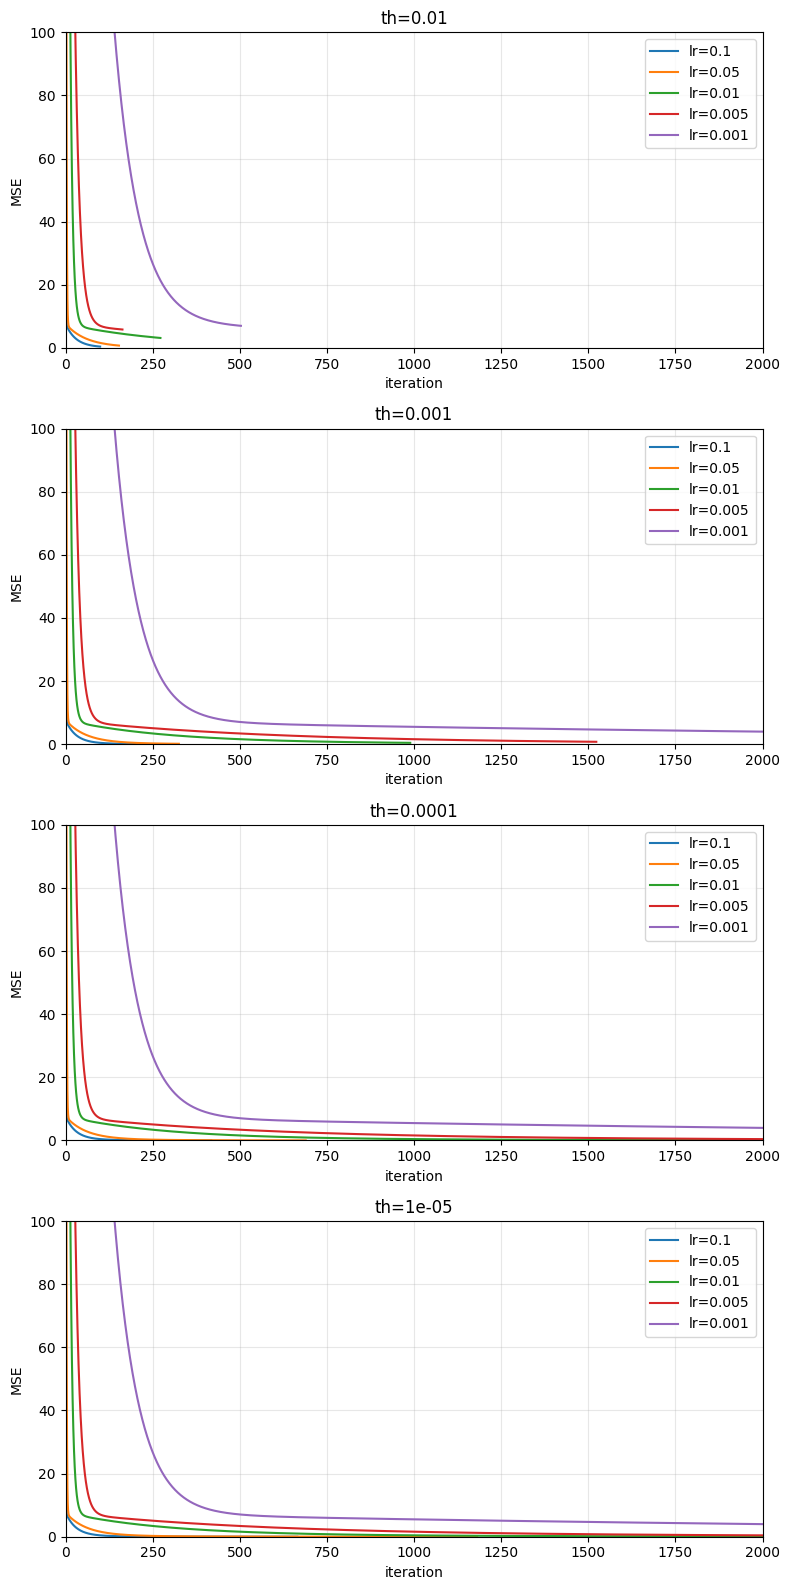

In [242]:
fig, axs = plt.subplots(len(thresholds), 1, figsize=(8, 16))

for i, threshold in enumerate(thresholds):
    for j, learning_rate in enumerate(learning_rates):
        gd = GradientDescentMse(X, y, learning_rate=learning_rate, threshold=threshold)
        gd.add_constant_feature()
        gd.learn()
        axs[i].plot(gd.objective_values, label=f"lr={learning_rate}")
        
    axs[i].set_title(f"th={threshold}")
    axs[i].set_xlabel("iteration")
    axs[i].set_ylabel("MSE")
    axs[i].set_ylim(0, 100)
    axs[i].set_xlim(0, 2000)
    axs[i].legend()
    axs[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
